# OCR/VLM 연습 노트북
LLaVA → BLIP-2 Q-Former → CLIP 순서로 가볍게 체험하면서 이미지→텍스트 파이프라인을 익히는 연습용 노트북입니다. GPU가 있으면 훨씬 빠르고, 없다면 작은 배치/짧은 토큰 길이로 테스트하세요.

## 0. 환경 준비
- 최신 `transformers`, `accelerate`, `torchvision`이 필요합니다.
- CUDA가 있다면 `torch`를 GPU 빌드로 설치하세요. CPU만 있다면 작은 입력으로만 간단히 돌려보세요.

In [ ]:
# 필요 시만 실행
!pip install -q transformers accelerate bitsandbytes sentencepiece torchvision pillow matplotlib

## 1) LLaVA 로컬 돌려보기
- 이미지 + 텍스트 프롬프트를 입력하면 바로 캡션/질문응답을 생성합니다.
- 모델은 `llava-hf/llava-1.5-7b-hf` 기준 예시입니다. GPU 16GB 이상이 권장되며, 없다면 4bit 양자화(`load_in_4bit=True`)로 시도할 수 있습니다.

In [10]:
import torch
from PIL import Image
import pillow_heif  # HEIC/HEIF 지원
from transformers import AutoProcessor, LlavaForConditionalGeneration

pillow_heif.register_heif_opener()

model_id = "llava-hf/llava-1.5-7b-hf"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
    low_cpu_mem_usage=True,
)

def run_llava(image_path: str, user_prompt: str, max_new_tokens: int = 128):
    image = Image.open(image_path).convert("RGB")
    prompt = f"USER: <image>\n{user_prompt}\nASSISTANT:"
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    if device == "cuda":
        inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.inference_mode():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return processor.decode(output[0], skip_special_tokens=True)

result = run_llava("./samples/IMG_5359.HEIC", "What do you see in the picture?")
print(result)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

USER:  
What do you see in the picture?
ASSISTANT: The image features a dining table with a white plate filled with a delicious meal of french fries. The plate is placed in the center of the table, and the fries are spread out, covering most of the plate's surface. 

In addition to the plate of fries, there is a bottle of Bud Light beer on the table, positioned towards the right side. A fork can also be seen on the left side of the table, likely used for enjoying the meal.


In [12]:
result = run_llava("./samples/1.png", "What do you see in the picture?")
print(result)

USER:  
What do you see in the picture?
ASSISTANT: The image features a serene lake with a group of rocks scattered throughout the water. The rocks vary in size and are positioned at different angles, creating a visually appealing scene. Some of the rocks are closer to the shore, while others are further out in the lake. The combination of the rocks and the calm water creates a peaceful atmosphere.


In [13]:
result = run_llava("./samples/IMG_5359.HEIC", "What color is beer tag?")
print(result)

USER:  
What color is beer tag?
ASSISTANT: The beer tag is blue.


## 2) BLIP-2 Q-Former 코드 읽기
- Q-Former는 이미지 feature를 질의(query) 토큰으로 뽑아내서 언어 모델로 넘겨줍니다.
- 실제 파라미터 로드 없이 구조와 forward 흐름을 `inspect`로 확인합니다.

In [1]:
import inspect
from transformers import Blip2Config
from transformers.models.blip_2.modeling_blip_2 import Blip2QFormerModel

config = Blip2Config.from_pretrained("Salesforce/blip2-opt-2.7b")
print("Q-Former hidden size:", config.qformer_config.hidden_size)
print("Cross-attention heads:", config.qformer_config.num_attention_heads)

source = inspect.getsource(Blip2QFormerModel.forward)
print(source)


Q-Former hidden size: 768
Cross-attention heads: 12
    @check_model_inputs
    @auto_docstring
    def forward(
        self,
        query_embeds: torch.FloatTensor,
        query_length: Optional[int] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        **kwargs: Unpack[TransformersKwargs],
    ) -> Union[tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
        r"""
        query_embeds (`torch.FloatTensor`  of shape `(batch_size, sequence_length, hidden_size)`):
            Hidden states to be used in the attention computation. If cross-attention,
            will be used for the query (i.e., key and value will use the encoder_hidden_states).
        query_length (`int`, *optional*):
            Length of the query, usually based on the number of query t

## 3) CLIP 임베딩 비교
- 이미지-이미지, 텍스트-이미지 cosine similarity를 직접 계산합니다.
- 모델은 `openai/clip-vit-large-patch14` 예시입니다. CPU에서도 동작하지만 느릴 수 있습니다.

In [2]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

clip_id = "openai/clip-vit-large-patch14"
clip_model = CLIPModel.from_pretrained(clip_id)
clip_processor = CLIPProcessor.from_pretrained(clip_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)

def normalize(x):
    return x / x.norm(dim=-1, keepdim=True)

def image_embed(path: str):
    image = Image.open(path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        feats = clip_model.get_image_features(**inputs)
    return normalize(feats)

def text_embed(texts):
    inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        feats = clip_model.get_text_features(**inputs)
    return normalize(feats)

# 이미지 두 장 similarity
# img_a = image_embed("./samples/a.jpg")
# img_b = image_embed("./samples/b.jpg")
# cos_sim = (img_a @ img_b.T).item()
# print(f"cosine similarity: {cos_sim:.3f}")

# 텍스트 vs 여러 이미지 중 가장 유사한 것 찾기
# captions = ["고양이가 누워 있는 사진", "강아지가 뛰어노는 사진"]
# text_feats = text_embed(captions)
# gallery = torch.vstack([image_embed(p) for p in ["./samples/a.jpg", "./samples/b.jpg"]])
# sims = text_feats @ gallery.T  # shape: (num_text, num_images)
# print("similarity matrix:", sims.cpu().numpy())
# best = sims.argmax(dim=-1)
# 리스트 인덱스를 이용해 어떤 이미지와 가장 잘 맞는지 확인


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
img_a = image_embed("./samples/image copy.png")
img_b = image_embed("./samples/image.png")
cos_sim = (img_a @ img_b.T).item() # 벡터 곱
print(f"cosine similarity: {cos_sim:.3f}")

cosine similarity: 0.752


In [23]:
# 1. 텍스트 준비 및 벡터화
# 한글 대신 영어로 시도해보세요
captions = ["A photo of a cat lying down", "A photo of a dog playing"]
text_feats = text_embed(captions)  # 텍스트를 벡터로 변환 (Shape: [2, 768] 등)

# 2. 이미지 갤러리 만들기
gallery = torch.vstack([img_a, img_b]) # 이미지 벡터들을 위아래로 쌓아서 뭉침 (Shape: [2, 768])

# 3. 모든 조합의 유사도 한방에 계산
sims = text_feats @ gallery.T  # (텍스트 2개) x (이미지 2개) = [2, 2] 행렬 생성
print(text_feats.shape)
print(gallery.T.shape)
print("similarity matrix:", sims.cpu().numpy())

# 4. 정답 찾기
best = sims.argmax(dim=-1) # 각 텍스트별로 점수가 가장 높은 이미지의 번호(인덱스)를 뽑음
print(best)

torch.Size([2, 768])
torch.Size([768, 2])
similarity matrix: [[0.22356556 0.25502792]
 [0.17639203 0.16045596]]
tensor([1, 0], device='cuda:0')


In [20]:
gallery.shape

torch.Size([2, 768])

In [26]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch

# 1. CLIP 모델 및 프로세스 불러오기
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# 2. 이미지 불러오기
url = "https://images.pexels.com/photos/248547/pexels-photo-248547.jpeg?auto=compress&cs=tinysrgb&w=800"
image = Image.open(requests.get(url, stream=True).raw)

# 3. 텍스트 리스트 정의하기
texts = ["고양이", "강아지", "자전거 타는 사람"]

# 4. 모델을 사용하기 위한 입력 준비
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)


torch.Size([1, 3])
torch.Size([3, 1])
고양이: 0.17
강아지: 0.28
자전거 타는 사람: 0.55
이 이미지는 '자전거 타는 사람'와 가장 유사합니다. (확률: 0.55)
확률 : tensor([[0.1709, 0.2786, 0.5505]])


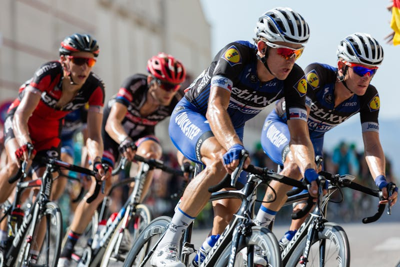

In [30]:

# 5. 모델 추론 및 유사도 계산
with torch.no_grad():
  outputs = model(**inputs)
  print(outputs.logits_per_image.shape)
  print(outputs.logits_per_text.shape)
  logits_per_image = outputs.logits_per_image  # (1, N_texts)
  probs = logits_per_image.softmax(dim=1)      # (1, N_texts)

# 6. 유사도 추출
logits_per_image = outputs.logits_per_image  # shape: [1, number_of_texts]
for text, prob in zip(texts, probs[0]):
    print(f"{text}: {prob.item():.2f}")

max_idx = probs.argmax().item()
print(f"이 이미지는 '{texts[max_idx]}'와 가장 유사합니다. (확률: {probs[0][max_idx].item():.2f})")

# 7. 확률 계산
probs = logits_per_image.softmax(dim=1)

print("확률 :", probs)

# 8. 이미지 출력
thumb_size = (400, 500)
image.thumbnail(thumb_size)  # 종횡비 유지하며 thumb_size 이내로 축소

display(image)

In [56]:
import requests
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from sentence_transformers import SentenceTransformer, util

# 1. BLIP 모델 및 프로세서 불러오기 (캡셔닝용)
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# 2. 이미지 불러오기
url = "https://images.pexels.com/photos/248547/pexels-photo-248547.jpeg?auto=compress&cs=tinysrgb&w=800"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image = Image.open("./samples/kitty.jpeg").convert("RGB")

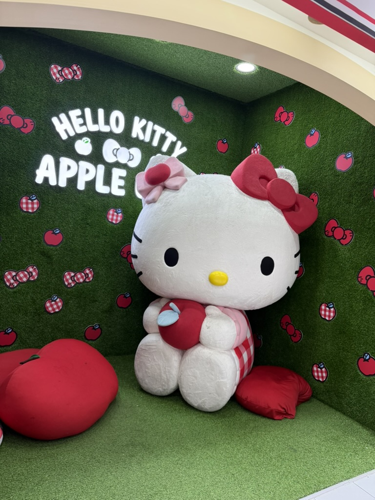

In [59]:
thumb_size = (400, 500)
image.thumbnail(thumb_size)  # 종횡비 유지하며 thumb_size 이내로 축소
display(image)

torch.Size([8])
tensor([30522,  7592, 14433,  6207,  1011,  7592, 14433,   102])
BLIP 생성 캡션: hello kitty apple - hello kitty
고양이: 0.70
강아지: 0.42
자전거 타는 사람: 0.09
이미지(캡션: 'hello kitty apple - hello kitty')는 '고양이'와 가장 유사합니다. (유사도: 0.70)


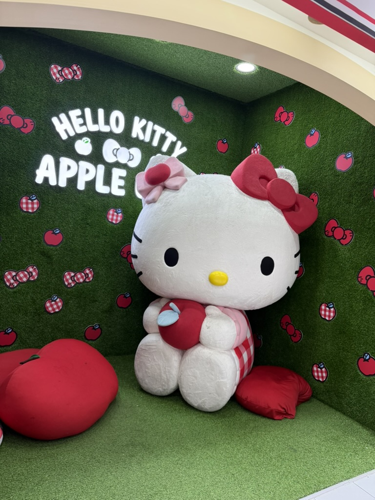

In [60]:

# 3. 이미지 캡션 생성
inputs = blip_processor(images=image, return_tensors="pt")
with torch.no_grad():
    output_ids = blip_model.generate(**inputs, max_length=20)
    print(output_ids[0].shape)
    print(output_ids[0])
caption = blip_processor.decode(output_ids[0], skip_special_tokens=True) #[0]은 첫번째 배치 사진이라서
print(f"BLIP 생성 캡션: {caption}")

# 4. 비교할 텍스트 리스트 정의
texts = ["고양이", "강아지", "자전거 타는 사람"]

# 5. 텍스트 임베딩 모델 로드 (문장 유사도 계산용)
embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# 6. 생성된 캡션과 후보 텍스트의 유사도 계산
caption_emb = embedder.encode(caption, convert_to_tensor=True)
texts_emb = embedder.encode(texts, convert_to_tensor=True)

cos_scores = util.pytorch_cos_sim(caption_emb, texts_emb)[0]

# 7. 결과 출력
for text, score in zip(texts, cos_scores):
    print(f"{text}: {score.item():.2f}")

max_idx = torch.argmax(cos_scores).item()
print(f"이미지(캡션: '{caption}')는 '{texts[max_idx]}'와 가장 유사합니다. (유사도: {cos_scores[max_idx].item():.2f})")

# 8. 이미지 출력
thumb_size = (400, 500)
image.thumbnail(thumb_size)
display(image)

In [47]:
output_ids[0][:3]

tensor([30522,  1037,  2177])

In [48]:
print(blip_processor.decode(output_ids[0][:3], skip_special_tokens=True))

a group


In [49]:
output_ids[0][3:5]

tensor([ 1997, 21912])

In [50]:
print(blip_processor.decode(output_ids[0][3:5], skip_special_tokens=True))

of cyclists


In [72]:
import torch
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

# 1. 모델 및 프로세서 로드
# (GPU 메모리가 부족하면 "Salesforce/blip2-opt-2.7b" 대신 더 작은 모델을 찾거나 8bit 로딩을 고려해야 합니다)
model_id = "Salesforce/blip2-opt-2.7b"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading BLIP-2 model: {model_id}...")
processor = Blip2Processor.from_pretrained(model_id)

model = Blip2ForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto" 
)

def run_blip2(image_path, question=None):
    image = Image.open(image_path).convert('RGB')
    
    if question:
        # 질문이 있는 경우 (VQA 모드)
        # 주의: BLIP-2는 질문 뒤에 팁을 주면 더 잘 대답함 (예: "Question: {} Answer:")
        prompt = f"Question: {question} Answer:"
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)
    else:
        # 질문이 없는 경우 (Captioning 모드)
        inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
    return generated_text


Loading BLIP-2 model: Salesforce/blip2-opt-2.7b...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [73]:

# --- 테스트 실행 ---
img_path = "./samples/kitty.jpeg" # 가지고 계신 이미지 경로로 수정하세요

# 1. 이미지 캡션 생성 (설명하기)
print("Caption:", run_blip2(img_path))

# 2. 이미지 질문 응답 (VQA)
print("VQA:", run_blip2(img_path, "What is in the picture?"))
print("VQA:", run_blip2(img_path, "What color is Hello Kitty's nose?"))

Caption: hello kitty apple store
VQA: Question: What is in the picture? Answer: Hello Kitty Apple
VQA: Question: What color is Hello Kitty's nose? Answer: It's pink
